**PanNuke Dataset Segmentation**

6 Masks 
* 0: Neoplastic cells
* 1: Inflammatory 
* 2: Connective/Soft tissue cells
* 3: Dead Cells
* 4: Epithelial 
* 6: Background

**Train, Test, Val Paths**

In [1]:
train_images_path = '/kaggle/input/pannuke-images-dataset/Pan Nuke - Reduced/train/images/'
train_masks_path = '/kaggle/input/pannuke-images-dataset/Pan Nuke - Reduced/train/masks/'

test_images_path = '/kaggle/input/pannuke-images-dataset/Pan Nuke - Reduced/test/images/'
test_masks_path = '/kaggle/input/pannuke-images-dataset/Pan Nuke - Reduced/test/masks/'

val_images_path = '/kaggle/input/pannuke-images-dataset/Pan Nuke - Reduced/val/images/'
val_masks_path = '/kaggle/input/pannuke-images-dataset/Pan Nuke - Reduced/val/masks/'

**Importing Libraries**

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, Concatenate, BatchNormalization, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.losses import Loss
from keras.backend import epsilon
from tensorflow import reduce_sum as sum
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

2024-05-05 12:20:25.059767: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 12:20:25.059883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 12:20:25.194545: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Train, Test, Val Images Names List**

In [3]:
# train images
train_image_names = os.listdir(train_images_path)[:2000]

# test images
test_image_names = os.listdir(test_images_path)[:1000]

# val images
val_image_names = os.listdir(val_images_path)[:1000]

**Display Images**

In [4]:
labels = {0: "Neoplastic cells",
1: "Inflammatory",
2: "Connective/Soft tissue cells",
3: "Dead Cells",
4: "Epithelial",
5: "Background"}

In [5]:
# function to display predicted images
def display(images):
    # loop through each set of images
    for i in range(images.shape[0]):
        # create a subplot for each set of images
        fig, axes = plt.subplots(1, images.shape[-1], figsize=(20, 4))
        
        k = 0  
        
        # loop through each image in the set
        for j in range(images.shape[-1]):
            # display the image on the corresponding subplot
            axes[j].imshow(images[i, :, :, j], cmap='gray')
            axes[j].axis('off') 
            axes[j].set_title(f'{labels[k]}')
            k += 1
        
        plt.show()

In [6]:
# display single mask of 256x256x6
def display_mask(image):
    plt.figure(figsize=(15, 10))
    for i in range(image.shape[-1]):
        plt.subplot(2, 3, i+1)
        plt.imshow(image[:, :, i],cmap="gray")
        plt.title(f'Channel {i}')
        plt.axis('off')
    plt.show()

In [7]:
# display single image
def display_image(image, text=None, channels=1):
    if channels == 1:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)

    if text:
        plt.text(0, 0, text, color='white', fontsize=12, ha='left', va='top', bbox=dict(facecolor='black', alpha=0.5))

    plt.axis('off')
    plt.show()

In [8]:
# display images before and after normalization
def display_images(images_path, original_image_names, normalized_images, num_images_to_display=1):
    
    # just to display original images
    original_images = []
    
    for img in train_image_names[:num_images_to_display]:
        image_path = os.path.join(images_path, img)
        image = cv2.imread(image_path)
        original_images.append(image)

    plt.figure(figsize=(12, 6))

    # display images before normalization
    for i in range(num_images_to_display):
        # Display original image
        plt.subplot(2, num_images_to_display, i+1)
        plt.imshow(original_images[i])
        plt.axis('off')

        # display normalized image
        plt.subplot(2, num_images_to_display, num_images_to_display+i+1)
        plt.imshow(normalized_images[i], cmap="gray")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

**Z-Score Normalization**

In [9]:
# normalizing using z-score
def z_score_normalization(image):
    
    image = image.astype(np.float32)

    # calculating mean
    mean = np.mean(image, axis=(0, 1))

    # calculating std
    std = np.std(image, axis=(0, 1))

    # normalization function
    # epsilon is added to avoid dividing by zero
    normalized_image = (image - mean) / (std + 1e-7)

    # convert to uint8 for image
    normalized_image = normalized_image.astype(np.uint8)

    return normalized_image

**Contours**

In [10]:
def contours(grayscale_image):

    # apply Canny edge detection to find edges
    edges = cv2.Canny(grayscale_image, 30, 150)

    # find contours
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # draw contours on the original image
    contour_image = np.zeros_like(grayscale_image)
    cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 1)

    return contour_image

**CLAHE**

In [11]:
def clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # applying CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
        
    return enhanced_img

**Preprocessing Images**

In [12]:
# preprocessing images
def preprocess_images(image_names, images_path):

    # creating empty list to store normalized images
    normalized_images = []

    for filename in image_names:

        # read image
        image_path = os.path.join(images_path, filename)
        image = cv2.imread(image_path)
        
        # applying clahe
        clahe_image = clahe(image)

        # apply z-score normalization
        normalized_image = z_score_normalization(clahe_image)
        
        # converting to grayscale image
        #grayscale_image = cv2.cvtColor(normalized_image, cv2.COLOR_BGR2GRAY)
        
        # applying contours
        #contour_image = contours(grayscale_image)

        # append normalized image to the list
        normalized_images.append(normalized_image)

    return normalized_images

**Applying Preprocessing on Images**

**Testing Preprocessing**

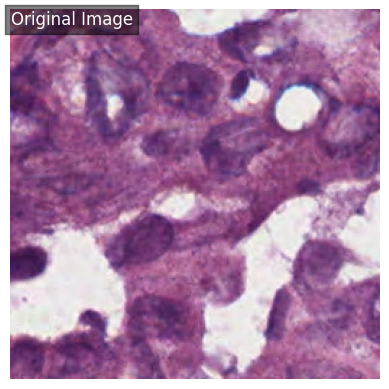

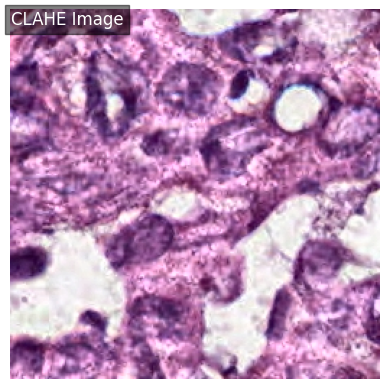

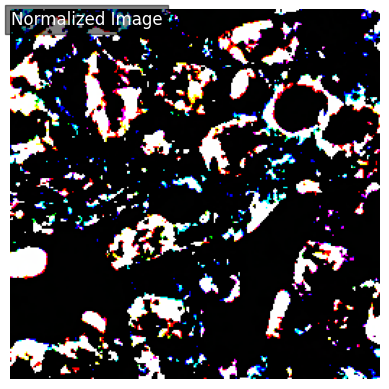

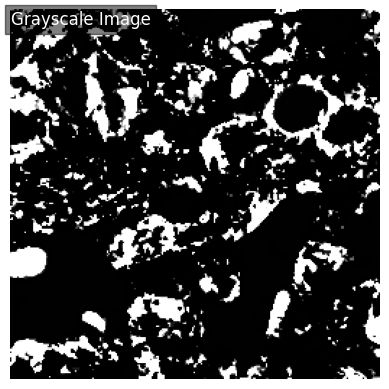

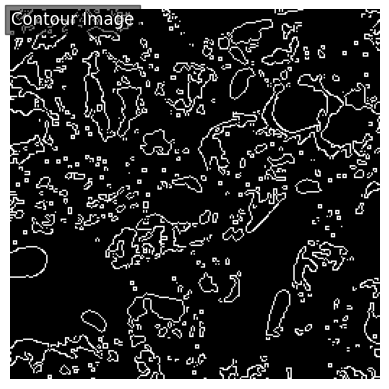

In [13]:
img_path = os.path.join(train_images_path, train_image_names[3])
img = cv2.imread(img_path)
display_image(img, text="Original Image", channels=3)
clahe_img = clahe(img)
display_image(clahe_img, text="CLAHE Image", channels=3)
normalized_img = z_score_normalization(clahe_img)
display_image(normalized_img, text="Normalized Image", channels=3)
grayscale_img = cv2.cvtColor(normalized_img, cv2.COLOR_BGR2GRAY)
display_image(grayscale_img, text="Grayscale Image", channels=1)
contour_img = contours(grayscale_img)
display_image(contour_img, text="Contour Image", channels=1)

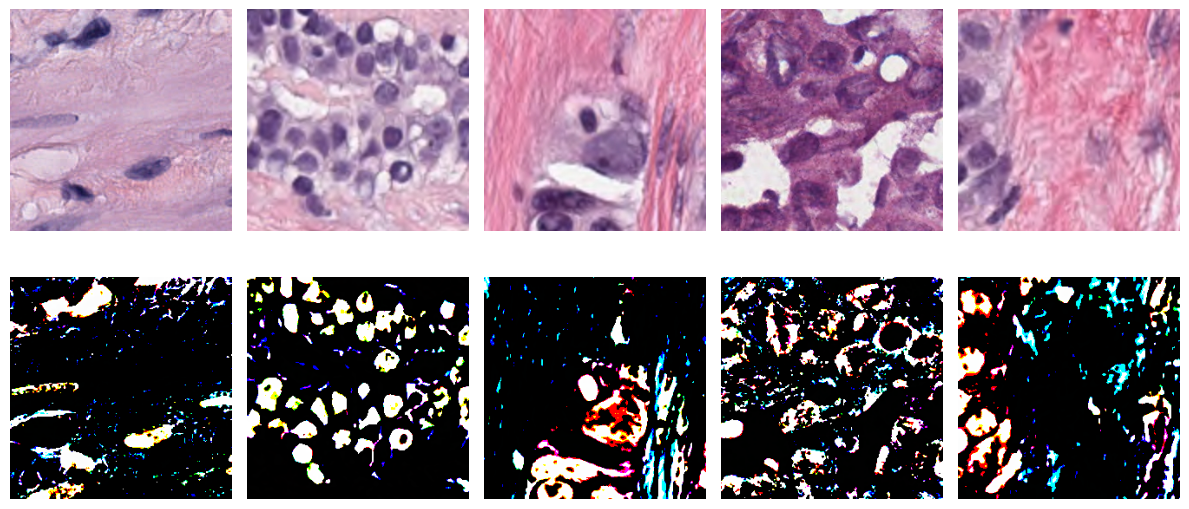

In [14]:
# preprocess training images
train_normalized_images = preprocess_images(train_image_names, train_images_path)

# preprocess test images
test_normalized_images = preprocess_images(test_image_names, test_images_path)

# preprocess validation images
val_normalized_images = preprocess_images(val_image_names, val_images_path)

# just to display first 5 images
train_imgs = []


# display images
# display first five
n= 5
display_images(train_images_path, train_image_names, train_normalized_images, n)

**Preprocessing Masks**

In [15]:
# getting masks of each image
def get_masks(image_names, mask_names):

    # creating empty list to store lists of masks for each image
    masks =  []

    for filename in image_names:

        # extract image name without extension
        image_name = os.path.splitext(filename)[0]

        # creating empty list to store 6 masks of each image
        m = []

        for i in range(1, 7):
            mask_path = os.path.join(mask_names, f"{image_name}.jpeg_mask_{i}.png")
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # apply threshold to convert grayscale mask image to binary
            _, binary_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)

            m.append(binary_mask)

        masks.append(m)

    return masks

In [16]:
# combining masks of each image
def combine_masks(mask_lists):
    
    combined_masks = []

    for masks in mask_lists:
        # stack the masks along a new axis to create a single image with six channels
        combined_mask = np.stack(masks, axis=-1)

        # append the combined mask to the list
        combined_masks.append(combined_mask)

    return combined_masks

**Calling Functions to Get Masks and Combine them**

In [17]:
# get train masks
train_masks = get_masks(train_image_names, train_masks_path)

# combined train masks
combined_train_masks = combine_masks(train_masks)

In [18]:
# get test masks
test_masks = get_masks(test_image_names, test_masks_path)

# combined test masks
combined_test_masks = combine_masks(test_masks)

In [19]:
# get val masks
val_masks = get_masks(val_image_names, val_masks_path)

# combined val masks
combined_val_masks = combine_masks(val_masks)

**Normalized Image and its Masks**

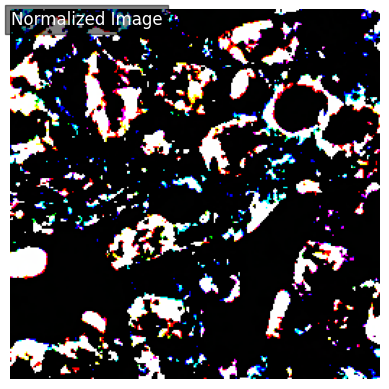

In [20]:
display_image(train_normalized_images[3], text="Normalized Image", channels=1)

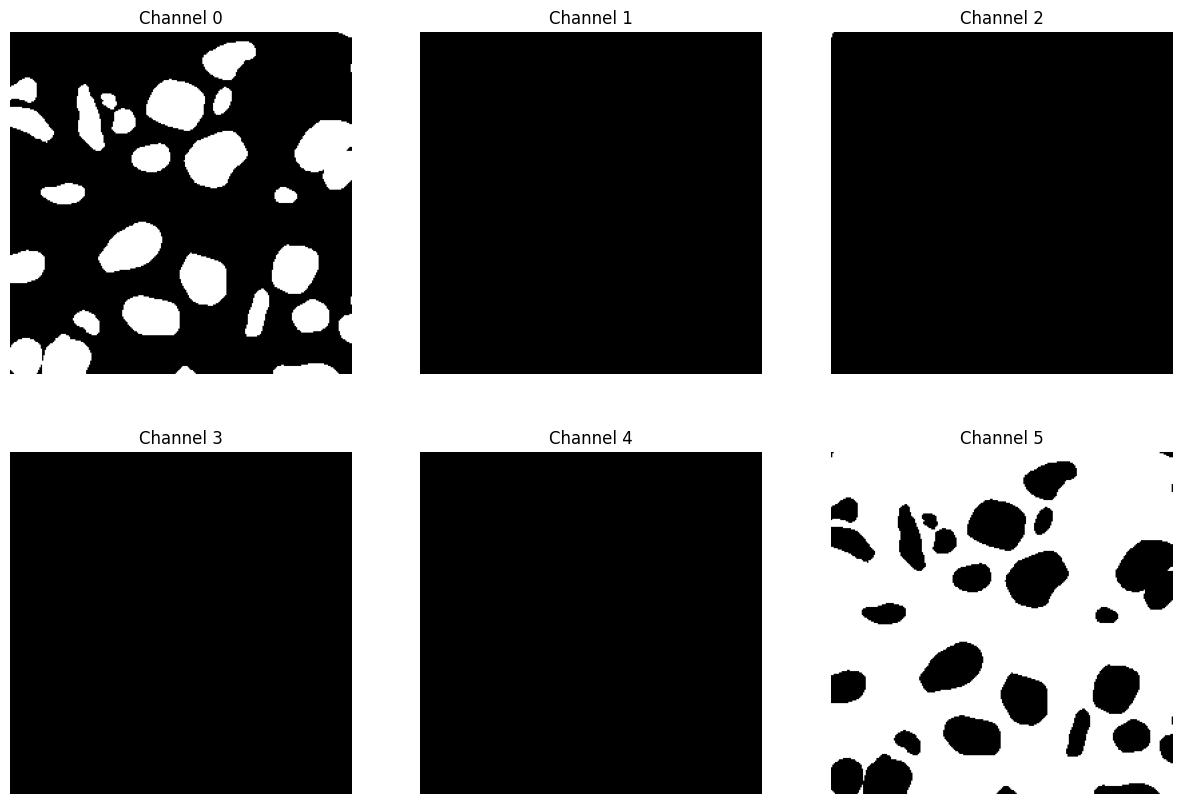

In [21]:
display_mask(combined_train_masks[3])

**Converting Numpy arrays to Tensors**

In [22]:
# tensor of train images
train_normalized_images = tf.convert_to_tensor(train_normalized_images)

In [23]:
# tensor of test images
test_normalized_images = tf.convert_to_tensor(test_normalized_images)

In [24]:
# tensor of val images
val_normalized_images = tf.convert_to_tensor(val_normalized_images)

In [25]:
# tensor of combined test masks
combined_train_masks = tf.convert_to_tensor(combined_train_masks)

In [26]:
# tensor of combined test masks
combined_test_masks = tf.convert_to_tensor(combined_test_masks)

In [27]:
# tensor of combined val masks
combined_val_masks = tf.convert_to_tensor(combined_val_masks)

**Dice Loss**

class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, epsilon=1e-6, name='dice_loss'):
        super().__init__(name=name)
        self.epsilon = epsilon

    def call(self, y_true, y_pred):
        dice_losses = []
        for i in range(y_true.shape[-1]):
            intersection = tf.reduce_sum(y_true[..., i] * y_pred[..., i])
            dice_coeff = (2. * intersection + self.epsilon) / (tf.reduce_sum(y_true[..., i]) + tf.reduce_sum(y_pred[..., i]) + self.epsilon)
            dice_losses.append(1. - dice_coeff)
        return tf.reduce_mean(dice_losses)

class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, epsilon=1e-6, name='dice_loss'):
        super().__init__(name=name)
        self.epsilon = epsilon

    def call(self, y_true, y_pred):
        dice_losses = []
        for i in range(y_true.shape[-1]):
            intersection = tf.reduce_sum(tf.cast(y_true[..., i], tf.float32) * tf.cast(y_pred[..., i], tf.float32))
            dice_coeff = (2. * intersection + self.epsilon) / (tf.reduce_sum(y_true[..., i]) + tf.reduce_sum(y_pred[..., i]) + self.epsilon) if tf.reduce_sum(y_true[..., i]) + tf.reduce_sum(y_pred[..., i]) != 0 else 0
            dice_losses.append(1. - dice_coeff)
        return tf.reduce_mean(dice_losses)

In [28]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, epsilon=1e-6, name='dice_loss'):
        super().__init__(name=name)
        self.epsilon = epsilon

    def call(self, y_true, y_pred):
        dice_losses = []
        for i in range(y_true.shape[-1]):
            intersection = tf.reduce_sum(y_true[..., i] * y_pred[..., i])
            dice_coeff = (2. * intersection + self.epsilon) / (tf.reduce_sum(y_true[..., i]) + tf.reduce_sum(y_pred[..., i]) + self.epsilon)
            dice_losses.append(1. - dice_coeff)
        return tf.reduce_mean(dice_losses)

**U-Net Model with Resnet Encoder**

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

In [ ]:
os.environ['SM_FRAMEWORK'] = 'tf.keras'

# 1. **VGG16**

In [31]:
import segmentation_models as sm
BACKBONE = 'vgg16'
#preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE, classes=6, activation="softmax")

Segmentation Models: using `tf.keras` framework.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [32]:
from tensorflow.keras.metrics import Precision, Recall
# getting the last layer to modify
output_layer = model.layers[-1]
# modifying last layer
model.layers[-1] = Conv2D(6, (1, 1), activation='softmax', name='output_layer')
model.compile(
    loss=DiceLoss(),
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, None,      │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, None,      │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, None,      │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, None,      │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, None,      │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, None,      │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, None,      │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, None,      │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, None,      │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, None,      │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, None,      │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, None,      │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, None,      │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, None,      │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, None,      │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, None,      │  2,359,808 │ block5_conv1[0][

 Total params: 23,752,998 (90.61 MB)

 Trainable params: 23,748,966 (90.60 MB)

 Non-trainable params: 4,032 (15.75 KB)

**Train Model**

In [ ]:
# model.fit(
#    x=train_normalized_images,
#    y=combined_train_masks,
#    batch_size=16,
#    epochs=30,
#    validation_data=(val_normalized_images, combined_val_masks),
# )

# Fit the model with early stopping
history = model.fit(
   x=train_normalized_images,  
   y=combined_train_masks,      
   batch_size=16,               
   epochs=30,                   
   validation_data=(val_normalized_images, combined_val_masks)
)

In [ ]:
import pandas as pd
df_result = pd.DataFrame(history.history)
df_resultdf_result = pd.DataFrame(history.history)
df_result

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Evaluate Model**

In [ ]:
# evaluate on test set
test_loss, test_dice = model.evaluate(test_normalized_images, combined_test_masks)
print(f'Test Loss: {test_loss:.4f}, Test Dice Coefficient: {test_dice:.4f}')

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

# Convert predictions and ground truth masks to binary masks
predictions_binary = np.argmax(predictions, axis=-1)
ground_truth_binary = np.argmax(combined_val_masks, axis=-1)

# Flatten predictions and ground truth masks
predictions_flat = predictions_binary.flatten()
ground_truth_flat = ground_truth_binary.flatten()

# Calculate precision
precision = precision_score(ground_truth_flat, predictions_flat, average='weighted', zero_division=1)

# Calculate recall
recall = recall_score(ground_truth_flat, predictions_flat, average='weighted', zero_division=1)

print("Precision:", precision)
print("Recall:", recall)


**Pipleline**

In [ ]:
def pipeline(image_names, images_path):
    norm_images = preprocess_images(image_names, images_path)
    #display_images(images_path, image_names, norm_images, len(image_names))
    img = tf.convert_to_tensor(norm_images)
    pred = model.predict(img)
    display(pred)

**Predicted Images**

In [ ]:
images_path = test_images_path
image_names= os.listdir(images_path)[12:17]

pipeline(image_names, images_path)

**Predicted Images Names**

In [ ]:
image_names

# **VGG19**

In [ ]:
import segmentation_models as sm
import pandas as pd
import matplotlib.pyplot as plt


BACKBONE = 'vgg19'
#preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE, classes=6, activation="softmax")
from tensorflow.keras.metrics import Precision, Recall
# getting the last layer to modify
output_layer = model.layers[-1]
# modifying last layer
model.layers[-1] = Conv2D(6, (1, 1), activation='softmax', name='output_layer')
model.compile(
    loss=DiceLoss(),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


history = model.fit(
   x=train_normalized_images,  
   y=combined_train_masks,      
   batch_size=16,               
   epochs=30,                   
   validation_data=(val_normalized_images, combined_val_masks)
)


df_result = pd.DataFrame(history.history)
df_resultdf_result = pd.DataFrame(history.history)
df_result


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# evaluate on test set
test_loss, test_dice = model.evaluate(test_normalized_images, combined_test_masks)
print(f'Test Loss: {test_loss:.4f}, Test Dice Coefficient: {test_dice:.4f}')

def pipeline(image_names, images_path):
    norm_images = preprocess_images(image_names, images_path)
    #display_images(images_path, image_names, norm_images, len(image_names))
    img = tf.convert_to_tensor(norm_images)
    pred = model.predict(img)
    display(pred)
    
    
images_path = test_images_path
image_names= os.listdir(images_path)[12:17]
pipeline(image_names, images_path)

import numpy as np
from sklearn.metrics import precision_score, recall_score

# Convert predictions and ground truth masks to binary masks
predictions_binary = np.argmax(predictions, axis=-1)
ground_truth_binary = np.argmax(combined_val_masks, axis=-1)

# Flatten predictions and ground truth masks
predictions_flat = predictions_binary.flatten()
ground_truth_flat = ground_truth_binary.flatten()

# Calculate precision
precision = precision_score(ground_truth_flat, predictions_flat, average='weighted', zero_division=1)

# Calculate recall
recall = recall_score(ground_truth_flat, predictions_flat, average='weighted', zero_division=1)

print("Precision:", precision)
print("Recall:", recall)


# **RESNET152**

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_52   │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d_5… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_53   │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_54   │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_5… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn3    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu3  │ (None, None,      │          0 │ stage1_unit1_bn3

 Total params: 67,295,919 (256.71 MB)

 Trainable params: 67,150,057 (256.16 MB)

 Non-trainable params: 145,862 (569.77 KB)

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 223s 541ms/step - accuracy: 0.5864 - loss: 0.4435 - val_accuracy: 0.0271 - val_loss: 0.7265
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 386ms/step - accuracy: 0.7372 - loss: 0.1542 - val_accuracy: 0.5879 - val_loss: 0.2982
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 386ms/step - accuracy: 0.7394 - loss: 0.0417 - val_accuracy: 0.7684 - val_loss: 0.4420
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 385ms/step - accuracy: 0.7480 - loss: 0.0022 - val_accuracy: 0.8023 - val_loss: 0.3153
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 386ms/step - accuracy: 0.7559 - loss: -0.0044 - val_accuracy: 0.6258 - val_loss: 0.1960
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 387ms/step - accuracy: 0.7469 - loss: -0.0356 - val_accuracy: 0.7162 - val_loss: 0.1387
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 387ms/step - accuracy: 0.7543 - loss: -0.0662 - val_accuracy: 0.8260 - val_loss: 0.0656
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 387ms/step - accuracy: 0.7679 - los

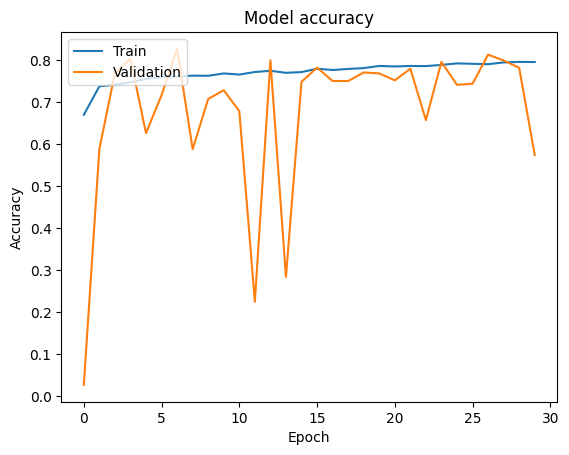

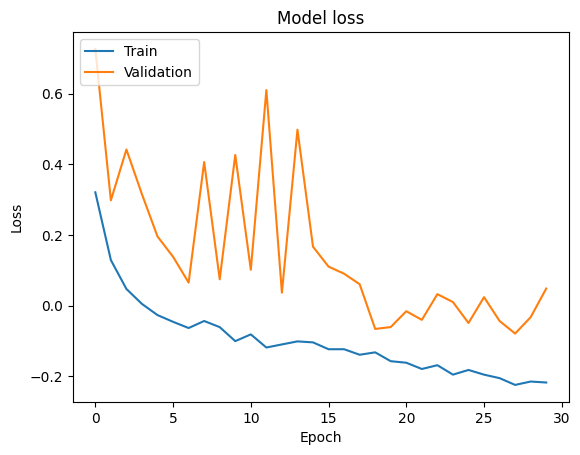

32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 184ms/step - accuracy: 0.5580 - loss: 0.0251
Test Loss: 0.0457, Test Dice Coefficient: 0.5610
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


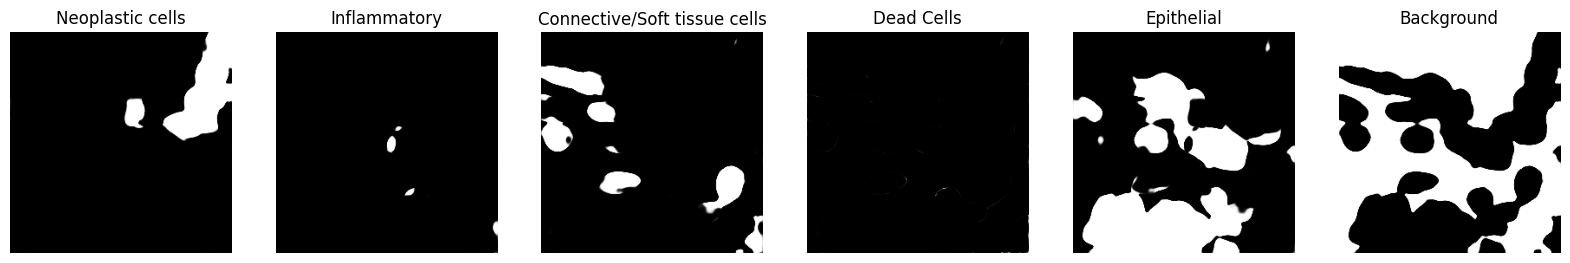

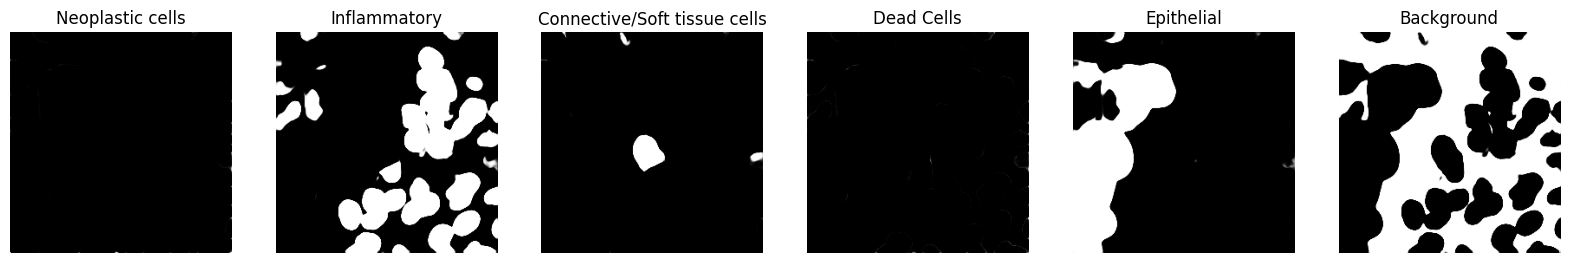

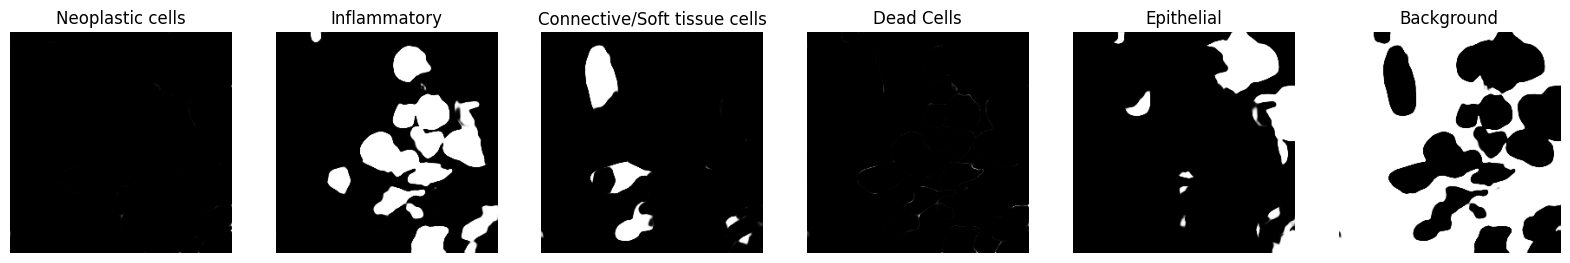

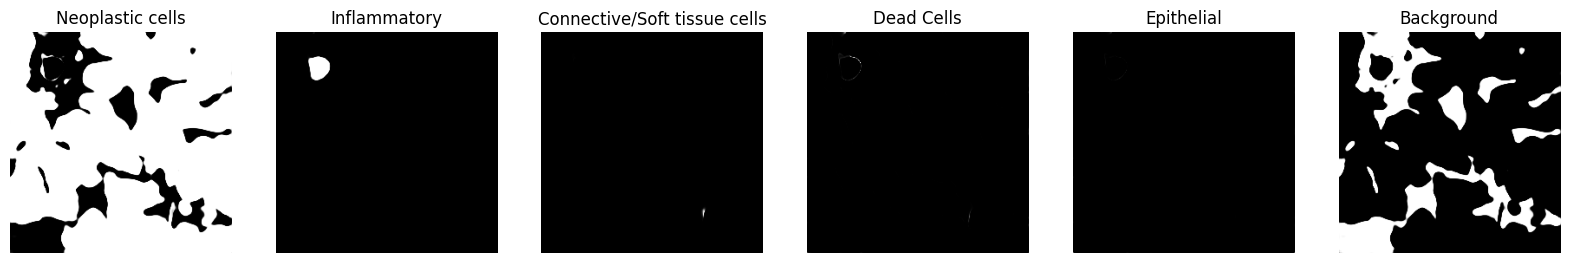

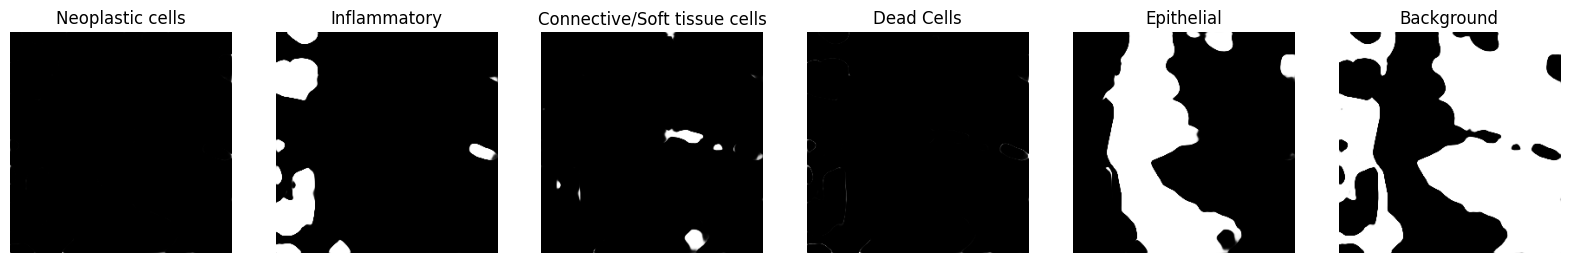

NameError: name 'predictions' is not defined

In [34]:
import segmentation_models as sm
import pandas as pd
import matplotlib.pyplot as plt


BACKBONE = 'resnet152'
#preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE, classes=6, activation="softmax")
from tensorflow.keras.metrics import Precision, Recall
# getting the last layer to modify
output_layer = model.layers[-1]
# modifying last layer
model.layers[-1] = Conv2D(6, (1, 1), activation='softmax', name='output_layer')
model.compile(
    loss=DiceLoss(),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


history = model.fit(
   x=train_normalized_images,  
   y=combined_train_masks,      
   batch_size=16,               
   epochs=30,                   
   validation_data=(val_normalized_images, combined_val_masks)
)


df_result = pd.DataFrame(history.history)
df_resultdf_result = pd.DataFrame(history.history)
df_result


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# evaluate on test set
test_loss, test_dice = model.evaluate(test_normalized_images, combined_test_masks)
print(f'Test Loss: {test_loss:.4f}, Test Dice Coefficient: {test_dice:.4f}')

def pipeline(image_names, images_path):
    norm_images = preprocess_images(image_names, images_path)
    #display_images(images_path, image_names, norm_images, len(image_names))
    img = tf.convert_to_tensor(norm_images)
    pred = model.predict(img)
    display(pred)
    
    
images_path = test_images_path
image_names= os.listdir(images_path)[12:17]
pipeline(image_names, images_path)

import numpy as np
from sklearn.metrics import precision_score, recall_score

# Convert predictions and ground truth masks to binary masks
predictions_binary = np.argmax(predictions, axis=-1)
ground_truth_binary = np.argmax(combined_val_masks, axis=-1)

# Flatten predictions and ground truth masks
predictions_flat = predictions_binary.flatten()
ground_truth_flat = ground_truth_binary.flatten()

# Calculate precision
precision = precision_score(ground_truth_flat, predictions_flat, average='weighted', zero_division=1)

# Calculate recall
recall = recall_score(ground_truth_flat, predictions_flat, average='weighted', zero_division=1)

print("Precision:", precision)
print("Recall:", recall)

# **seresnet152**

In [ ]:
# import segmentation_models as sm
# import pandas as pd
# import matplotlib.pyplot as plt


# BACKBONE = 'seresnet152'
# #preprocess_input = sm.get_preprocessing(BACKBONE)
# model = sm.Unet(BACKBONE, classes=6, activation="softmax")
# from tensorflow.keras.metrics import Precision, Recall
# # getting the last layer to modify
# output_layer = model.layers[-1]
# # modifying last layer
# model.layers[-1] = Conv2D(6, (1, 1), activation='softmax', name='output_layer')
# model.compile(
#     loss=DiceLoss(),
#     optimizer='adam',
#     metrics=['accuracy']
# )

# model.summary()


# history = model.fit(
#    x=train_normalized_images,  
#    y=combined_train_masks,      
#    batch_size=16,               
#    epochs=30,                   
#    validation_data=(val_normalized_images, combined_val_masks)
# )


# df_result = pd.DataFrame(history.history)
# df_resultdf_result = pd.DataFrame(history.history)
# df_result


# # Plot training & validation accuracy values
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()


# # evaluate on test set
# test_loss, test_dice = model.evaluate(test_normalized_images, combined_test_masks)
# print(f'Test Loss: {test_loss:.4f}, Test Dice Coefficient: {test_dice:.4f}')

# def pipeline(image_names, images_path):
#     norm_images = preprocess_images(image_names, images_path)
#     #display_images(images_path, image_names, norm_images, len(image_names))
#     img = tf.convert_to_tensor(norm_images)
#     pred = model.predict(img)
#     display(pred)
    
    
# images_path = test_images_path
# image_names= os.listdir(images_path)[12:17]
# pipeline(image_names, images_path)

# import numpy as np
# from sklearn.metrics import precision_score, recall_score

# # Convert predictions and ground truth masks to binary masks
# predictions_binary = np.argmax(predictions, axis=-1)
# ground_truth_binary = np.argmax(combined_val_masks, axis=-1)

# # Flatten predictions and ground truth masks
# predictions_flat = predictions_binary.flatten()
# ground_truth_flat = ground_truth_binary.flatten()

# # Calculate precision
# precision = precision_score(ground_truth_flat, predictions_flat, average='weighted', zero_division=1)

# # Calculate recall
# recall = recall_score(ground_truth_flat, predictions_flat, average='weighted', zero_division=1)

# print("Precision:", precision)
# print("Recall:", recall)


# **resnext101**

In [ ]:
# import segmentation_models as sm
# import pandas as pd
# import matplotlib.pyplot as plt


# BACKBONE = 'resnext101'
# #preprocess_input = sm.get_preprocessing(BACKBONE)
# model = sm.Unet(BACKBONE, classes=6, activation="softmax")
# from tensorflow.keras.metrics import Precision, Recall
# # getting the last layer to modify
# output_layer = model.layers[-1]
# # modifying last layer
# model.layers[-1] = Conv2D(6, (1, 1), activation='softmax', name='output_layer')
# model.compile(
#     loss=DiceLoss(),
#     optimizer='adam',
#     metrics=['accuracy']
# )

# model.summary()


# history = model.fit(
#    x=train_normalized_images,  
#    y=combined_train_masks,      
#    batch_size=16,               
#    epochs=30,                   
#    validation_data=(val_normalized_images, combined_val_masks)
# )


# df_result = pd.DataFrame(history.history)
# df_resultdf_result = pd.DataFrame(history.history)
# df_result


# # Plot training & validation accuracy values
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()


# # evaluate on test set
# test_loss, test_dice = model.evaluate(test_normalized_images, combined_test_masks)
# print(f'Test Loss: {test_loss:.4f}, Test Dice Coefficient: {test_dice:.4f}')

# def pipeline(image_names, images_path):
#     norm_images = preprocess_images(image_names, images_path)
#     #display_images(images_path, image_names, norm_images, len(image_names))
#     img = tf.convert_to_tensor(norm_images)
#     pred = model.predict(img)
#     display(pred)
    
    
# images_path = test_images_path
# image_names= os.listdir(images_path)[12:17]
# pipeline(image_names, images_path)

# import numpy as np
# from sklearn.metrics import precision_score, recall_score

# # Convert predictions and ground truth masks to binary masks
# predictions_binary = np.argmax(predictions, axis=-1)
# ground_truth_binary = np.argmax(combined_val_masks, axis=-1)

# # Flatten predictions and ground truth masks
# predictions_flat = predictions_binary.flatten()
# ground_truth_flat = ground_truth_binary.flatten()

# # Calculate precision
# precision = precision_score(ground_truth_flat, predictions_flat, average='weighted', zero_division=1)

# # Calculate recall
# recall = recall_score(ground_truth_flat, predictions_flat, average='weighted', zero_division=1)

# print("Precision:", precision)
# print("Recall:", recall)


# **inceptionv3**

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │        864 │ input_layer_1[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │      9,216 │ activation[0][0]  │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │     18,432 │ activation_1[0][… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, None,      │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │      5,120 │ max_pooling2d[0]… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │    138,240 │ activation_3[0][… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, None,      │          0 │ batch_normalizat

 Total params: 29,933,830 (114.19 MB)

 Trainable params: 29,897,414 (114.05 MB)

 Non-trainable params: 36,416 (142.25 KB)

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 149s 373ms/step - accuracy: 0.5289 - loss: 0.3616 - val_accuracy: 0.0271 - val_loss: 0.7265
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 216ms/step - accuracy: 0.7390 - loss: 0.0014 - val_accuracy: 0.7374 - val_loss: 0.1381
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 216ms/step - accuracy: 0.7612 - loss: -0.0540 - val_accuracy: 0.6903 - val_loss: 0.2140
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 216ms/step - accuracy: 0.7585 - loss: -0.0372 - val_accuracy: 0.7394 - val_loss: 0.0634
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 216ms/step - accuracy: 0.7615 - loss: -0.0457 - val_accuracy: 0.6576 - val_loss: 0.1550
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 216ms/step - accuracy: 0.7713 - loss: -0.1023 - val_accuracy: 0.7454 - val_loss: 0.2028
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 216ms/step - accuracy: 0.7768 - loss: -0.0289 - val_accuracy: 0.5984 - val_loss: 0.1781
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 217ms/step - accuracy: 0.7834 - l

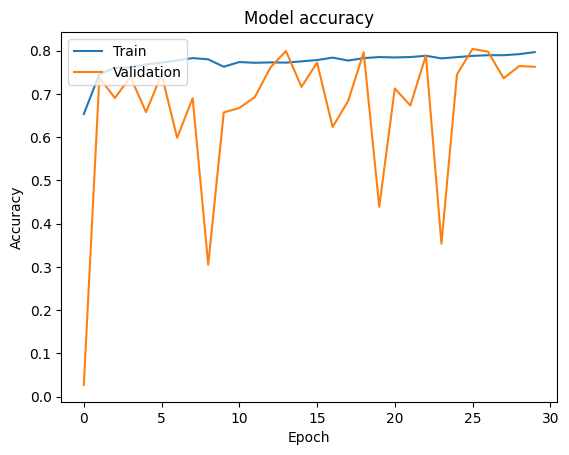

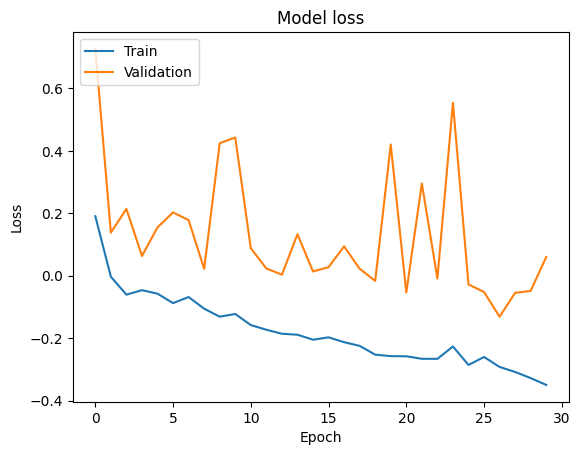

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.7689 - loss: -0.0107
Test Loss: -0.0040, Test Dice Coefficient: 0.7624
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


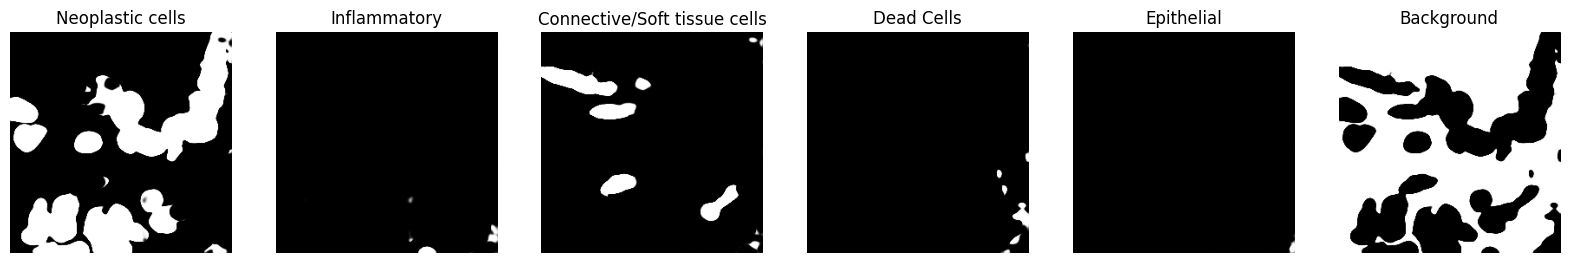

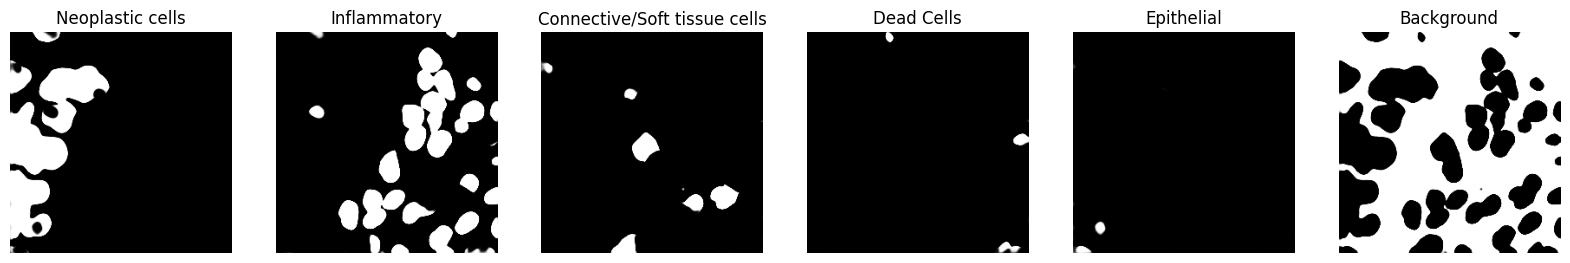

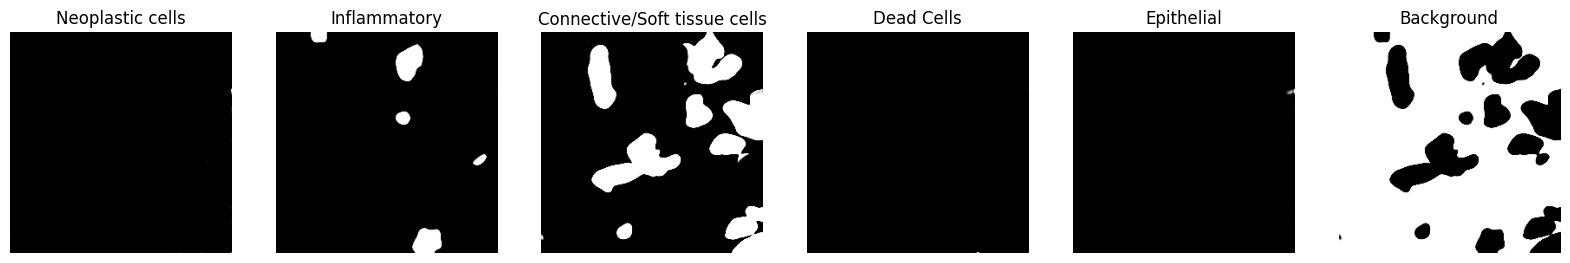

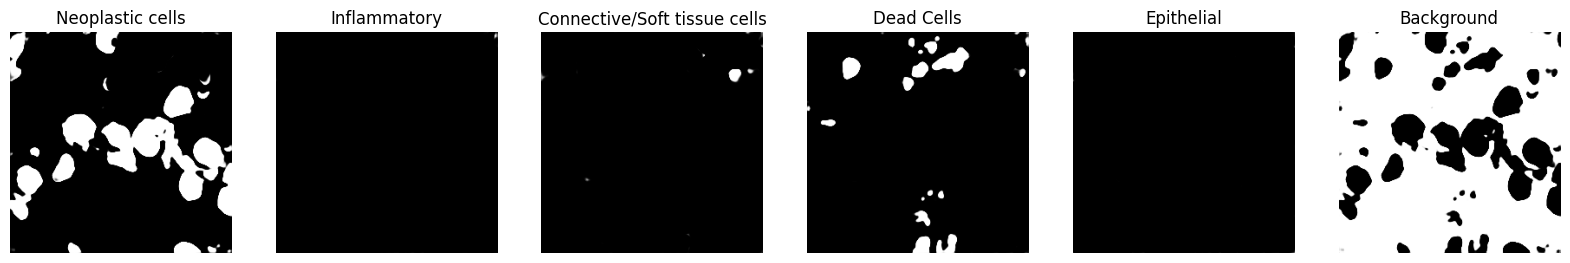

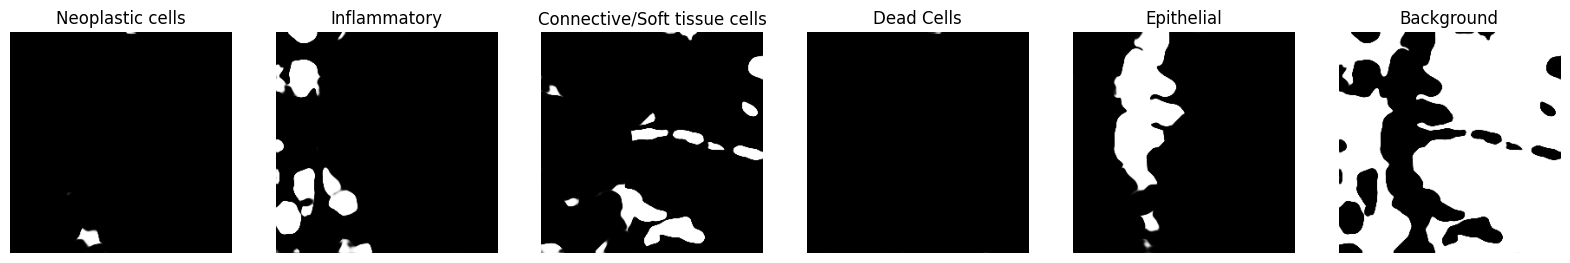

In [35]:
import segmentation_models as sm
import pandas as pd
import matplotlib.pyplot as plt


BACKBONE = 'inceptionv3'
#preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE, classes=6, activation="softmax")
from tensorflow.keras.metrics import Precision, Recall
# getting the last layer to modify
output_layer = model.layers[-1]
# modifying last layer
model.layers[-1] = Conv2D(6, (1, 1), activation='softmax', name='output_layer')
model.compile(
    loss=DiceLoss(),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


history = model.fit(
   x=train_normalized_images,  
   y=combined_train_masks,      
   batch_size=16,               
   epochs=30,                   
   validation_data=(val_normalized_images, combined_val_masks)
)


df_result = pd.DataFrame(history.history)
df_resultdf_result = pd.DataFrame(history.history)
df_result


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# evaluate on test set
test_loss, test_dice = model.evaluate(test_normalized_images, combined_test_masks)
print(f'Test Loss: {test_loss:.4f}, Test Dice Coefficient: {test_dice:.4f}')

def pipeline(image_names, images_path):
    norm_images = preprocess_images(image_names, images_path)
    #display_images(images_path, image_names, norm_images, len(image_names))
    img = tf.convert_to_tensor(norm_images)
    pred = model.predict(img)
    display(pred)
    
    
images_path = test_images_path
image_names= os.listdir(images_path)[12:17]
pipeline(image_names, images_path)



# **inceptionresnetv2**

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, None,      │        864 │ input_layer_2[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, None,      │      9,216 │ activation_94[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, None,      │     18,432 │ activation_95[0]… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, None,      │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, None,      │      5,120 │ max_pooling2d_4[… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, None,      │    138,240 │ activation_97[0]… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, None,      │          0 │ batch_normalizat

 Total params: 62,062,278 (236.75 MB)

 Trainable params: 61,999,750 (236.51 MB)

 Non-trainable params: 62,528 (244.25 KB)

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 285s 612ms/step - accuracy: 0.6162 - loss: 0.3516 - val_accuracy: 0.2410 - val_loss: 0.5675
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 390ms/step - accuracy: 0.7511 - loss: -0.0161 - val_accuracy: 0.7908 - val_loss: 0.4497
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 390ms/step - accuracy: 0.7543 - loss: -0.0193 - val_accuracy: 0.7185 - val_loss: 0.1049
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 390ms/step - accuracy: 0.7695 - loss: -0.0938 - val_accuracy: 0.7409 - val_loss: 0.0366
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 389ms/step - accuracy: 0.7720 - loss: -0.1052 - val_accuracy: 0.6295 - val_loss: 0.1523
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 390ms/step - accuracy: 0.7750 - loss: -0.1582 - val_accuracy: 0.7844 - val_loss: 0.1166
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 389ms/step - accuracy: 0.7753 - loss: -0.1202 - val_accuracy: 0.7536 - val_loss: 0.0406
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 389ms/step - accuracy: 0.7823 - 

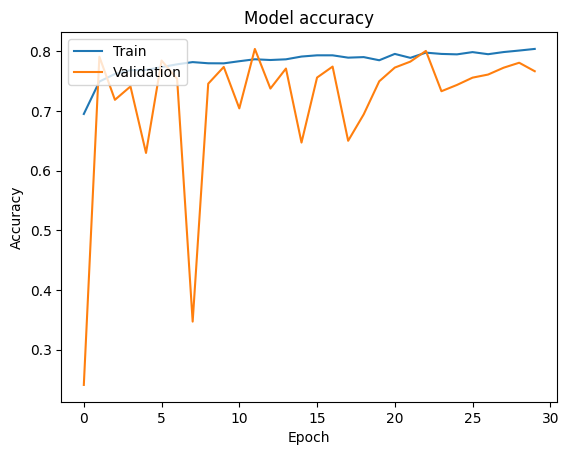

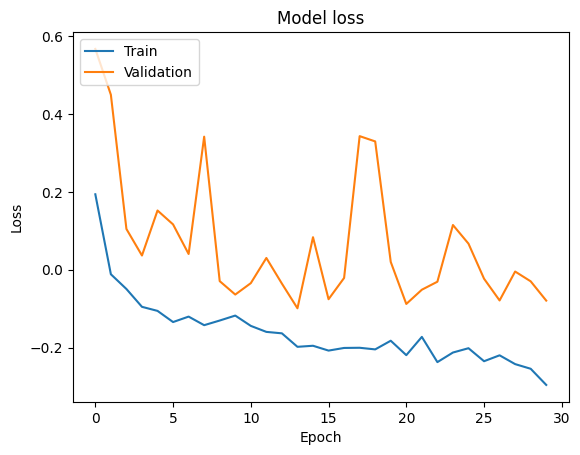

32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 180ms/step - accuracy: 0.7750 - loss: -0.1343
Test Loss: -0.1103, Test Dice Coefficient: 0.7712
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step


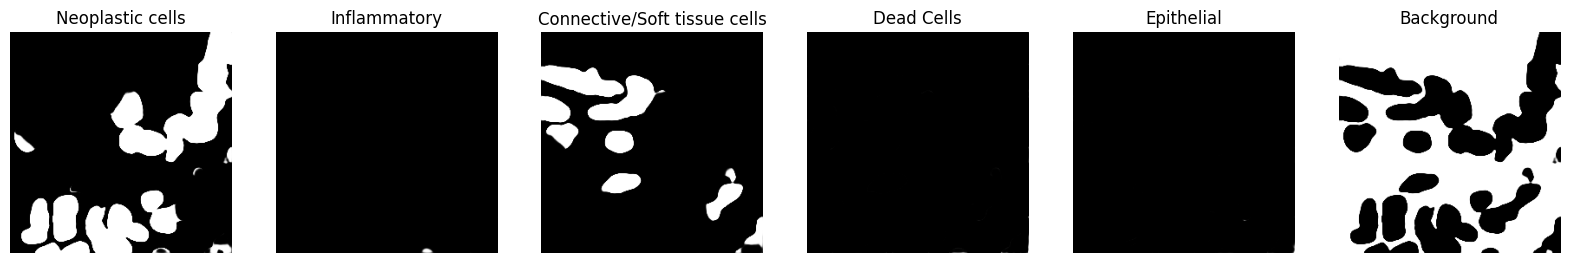

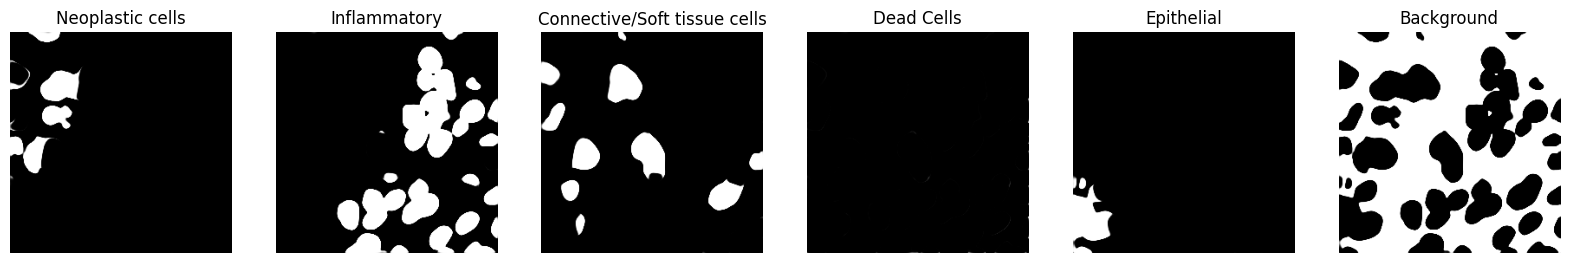

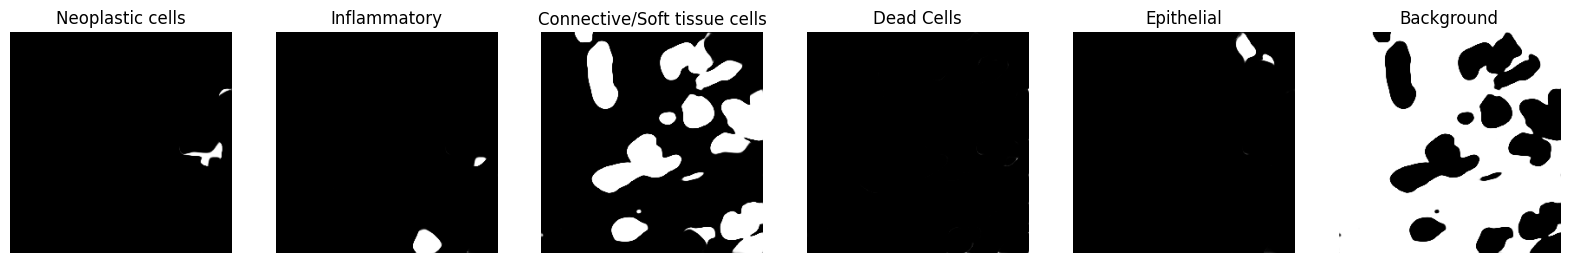

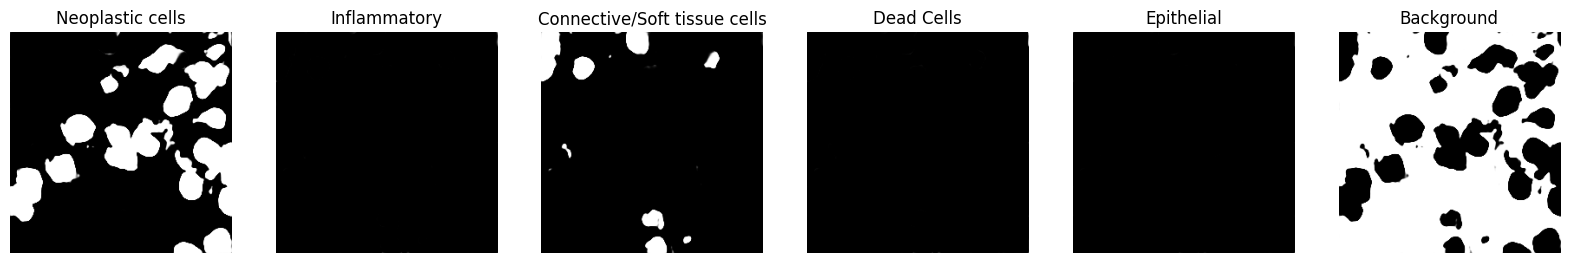

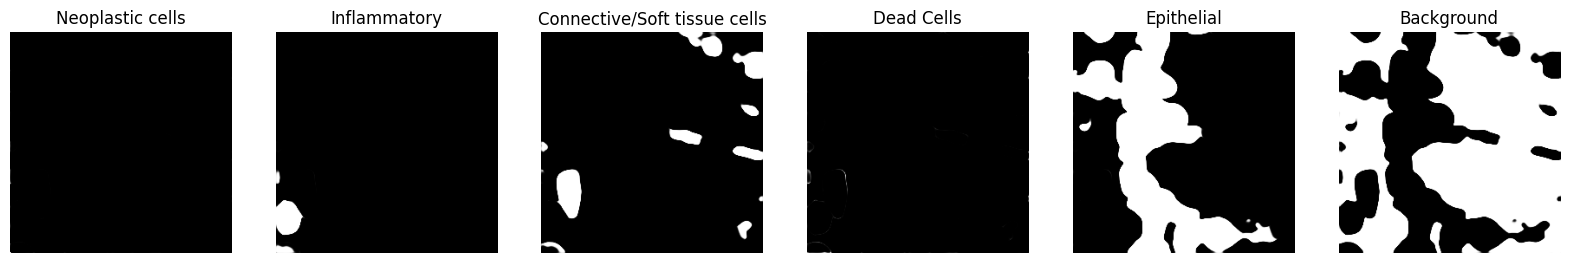

In [36]:
import segmentation_models as sm
import pandas as pd
import matplotlib.pyplot as plt


BACKBONE = 'inceptionresnetv2'
#preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE, classes=6, activation="softmax")
from tensorflow.keras.metrics import Precision, Recall
# getting the last layer to modify
output_layer = model.layers[-1]
# modifying last layer
model.layers[-1] = Conv2D(6, (1, 1), activation='softmax', name='output_layer')
model.compile(
    loss=DiceLoss(),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


history = model.fit(
   x=train_normalized_images,  
   y=combined_train_masks,      
   batch_size=16,               
   epochs=30,                   
   validation_data=(val_normalized_images, combined_val_masks)
)


df_result = pd.DataFrame(history.history)
df_resultdf_result = pd.DataFrame(history.history)
df_result


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# evaluate on test set
test_loss, test_dice = model.evaluate(test_normalized_images, combined_test_masks)
print(f'Test Loss: {test_loss:.4f}, Test Dice Coefficient: {test_dice:.4f}')

def pipeline(image_names, images_path):
    norm_images = preprocess_images(image_names, images_path)
    #display_images(images_path, image_names, norm_images, len(image_names))
    img = tf.convert_to_tensor(norm_images)
    pred = model.predict(img)
    display(pred)
    
    
images_path = test_images_path
image_names= os.listdir(images_path)[12:17]
pipeline(image_names, images_path)


# **inceptionv3**

In [ ]:
import segmentation_models as sm
import pandas as pd
import matplotlib.pyplot as plt


BACKBONE = 'inceptionv3'
#preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE, classes=6, activation="softmax")
from tensorflow.keras.metrics import Precision, Recall
# getting the last layer to modify
output_layer = model.layers[-1]
# modifying last layer
model.layers[-1] = Conv2D(6, (1, 1), activation='softmax', name='output_layer')
model.compile(
    loss=DiceLoss(),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


history = model.fit(
   x=train_normalized_images,  
   y=combined_train_masks,      
   batch_size=16,               
   epochs=30,                   
   validation_data=(val_normalized_images, combined_val_masks)
)


df_result = pd.DataFrame(history.history)
df_resultdf_result = pd.DataFrame(history.history)
df_result


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# evaluate on test set
test_loss, test_dice = model.evaluate(test_normalized_images, combined_test_masks)
print(f'Test Loss: {test_loss:.4f}, Test Dice Coefficient: {test_dice:.4f}')

def pipeline(image_names, images_path):
    norm_images = preprocess_images(image_names, images_path)
    #display_images(images_path, image_names, norm_images, len(image_names))
    img = tf.convert_to_tensor(norm_images)
    pred = model.predict(img)
    display(pred)
    
    
images_path = test_images_path
image_names= os.listdir(images_path)[12:17]
pipeline(image_names, images_path)



# **mobilenet**

In [ ]:
import segmentation_models as sm
import pandas as pd
import matplotlib.pyplot as plt


BACKBONE = 'mobilenet'
#preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE, classes=6, activation="softmax")
from tensorflow.keras.metrics import Precision, Recall
# getting the last layer to modify
output_layer = model.layers[-1]
# modifying last layer
model.layers[-1] = Conv2D(6, (1, 1), activation='softmax', name='output_layer')
model.compile(
    loss=DiceLoss(),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


history = model.fit(
   x=train_normalized_images,  
   y=combined_train_masks,      
   batch_size=16,               
   epochs=30,                   
   validation_data=(val_normalized_images, combined_val_masks)
)


df_result = pd.DataFrame(history.history)
df_resultdf_result = pd.DataFrame(history.history)
df_result


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# evaluate on test set
test_loss, test_dice = model.evaluate(test_normalized_images, combined_test_masks)
print(f'Test Loss: {test_loss:.4f}, Test Dice Coefficient: {test_dice:.4f}')

def pipeline(image_names, images_path):
    norm_images = preprocess_images(image_names, images_path)
    #display_images(images_path, image_names, norm_images, len(image_names))
    img = tf.convert_to_tensor(norm_images)
    pred = model.predict(img)
    display(pred)
    
    
images_path = test_images_path
image_names= os.listdir(images_path)[12:17]
pipeline(image_names, images_path)



# **mobilenetv2**

In [ ]:
import segmentation_models as sm
import pandas as pd
import matplotlib.pyplot as plt


BACKBONE = 'mobilenetv2'
#preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE, classes=6, activation="softmax")
from tensorflow.keras.metrics import Precision, Recall
# getting the last layer to modify
output_layer = model.layers[-1]
# modifying last layer
model.layers[-1] = Conv2D(6, (1, 1), activation='softmax', name='output_layer')
model.compile(
    loss=DiceLoss(),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


history = model.fit(
   x=train_normalized_images,  
   y=combined_train_masks,      
   batch_size=16,               
   epochs=30,                   
   validation_data=(val_normalized_images, combined_val_masks)
)


df_result = pd.DataFrame(history.history)
df_resultdf_result = pd.DataFrame(history.history)
df_result


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# evaluate on test set
test_loss, test_dice = model.evaluate(test_normalized_images, combined_test_masks)
print(f'Test Loss: {test_loss:.4f}, Test Dice Coefficient: {test_dice:.4f}')

def pipeline(image_names, images_path):
    norm_images = preprocess_images(image_names, images_path)
    #display_images(images_path, image_names, norm_images, len(image_names))
    img = tf.convert_to_tensor(norm_images)
    pred = model.predict(img)
    display(pred)
    
    
images_path = test_images_path
image_names= os.listdir(images_path)[12:17]
pipeline(image_names, images_path)



/opt/conda/lib/python3.10/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_pad           │ (None, None,      │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, None,      │        864 │ Conv1_pad[0][0]   │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, None,      │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, None,      │          0 │ bn_Conv1[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │          0 │ expanded_conv_de… │
│ (ReLU)              │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │        512 │ expanded_conv_de… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, None,      │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, None,      │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, None,      │          0 │ block_1_expand_B… │
│ (ReLU)              │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, None,      │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, None,      │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │          0 │ block_1_depthwis

 Total params: 8,048,166 (30.70 MB)

 Trainable params: 8,012,070 (30.56 MB)

 Non-trainable params: 36,096 (141.00 KB)

Epoch 1/30


# **resnet101**

In [ ]:
import segmentation_models as sm
import pandas as pd
import matplotlib.pyplot as plt


BACKBONE = 'resnet101'
#preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE, classes=6, activation="softmax")
from tensorflow.keras.metrics import Precision, Recall
# getting the last layer to modify
output_layer = model.layers[-1]
# modifying last layer
model.layers[-1] = Conv2D(6, (1, 1), activation='softmax', name='output_layer')
model.compile(
    loss=DiceLoss(),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


history = model.fit(
   x=train_normalized_images,  
   y=combined_train_masks,      
   batch_size=16,               
   epochs=30,                   
   validation_data=(val_normalized_images, combined_val_masks)
)


df_result = pd.DataFrame(history.history)
df_resultdf_result = pd.DataFrame(history.history)
df_result


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# evaluate on test set
test_loss, test_dice = model.evaluate(test_normalized_images, combined_test_masks)
print(f'Test Loss: {test_loss:.4f}, Test Dice Coefficient: {test_dice:.4f}')

def pipeline(image_names, images_path):
    norm_images = preprocess_images(image_names, images_path)
    #display_images(images_path, image_names, norm_images, len(image_names))
    img = tf.convert_to_tensor(norm_images)
    pred = model.predict(img)
    display(pred)
    

images_path = test_images_path
image_names= os.listdir(images_path)[12:17]
pipeline(image_names, images_path)

# **efficientnetb0**

In [ ]:
import segmentation_models as sm
import pandas as pd
import matplotlib.pyplot as plt


BACKBONE = 'efficientnetb0'
#preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE, classes=6, activation="softmax")
from tensorflow.keras.metrics import Precision, Recall
# getting the last layer to modify
output_layer = model.layers[-1]
# modifying last layer
model.layers[-1] = Conv2D(6, (1, 1), activation='softmax', name='output_layer')
model.compile(
    loss=DiceLoss(),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


history = model.fit(
   x=train_normalized_images,  
   y=combined_train_masks,      
   batch_size=16,               
   epochs=30,                   
   validation_data=(val_normalized_images, combined_val_masks)
)


df_result = pd.DataFrame(history.history)
df_resultdf_result = pd.DataFrame(history.history)
df_result


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# evaluate on test set
test_loss, test_dice = model.evaluate(test_normalized_images, combined_test_masks)
print(f'Test Loss: {test_loss:.4f}, Test Dice Coefficient: {test_dice:.4f}')

def pipeline(image_names, images_path):
    norm_images = preprocess_images(image_names, images_path)
    #display_images(images_path, image_names, norm_images, len(image_names))
    img = tf.convert_to_tensor(norm_images)
    pred = model.predict(img)
    display(pred)
    

images_path = test_images_path
image_names= os.listdir(images_path)[12:17]
pipeline(image_names, images_path)

#  **efficientnetb3**

In [ ]:
import segmentation_models as sm
import pandas as pd
import matplotlib.pyplot as plt


BACKBONE = 'efficientnetb3'
#preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE, classes=6, activation="softmax")
from tensorflow.keras.metrics import Precision, Recall
# getting the last layer to modify
output_layer = model.layers[-1]
# modifying last layer
model.layers[-1] = Conv2D(6, (1, 1), activation='softmax', name='output_layer')
model.compile(
    loss=DiceLoss(),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


history = model.fit(
   x=train_normalized_images,  
   y=combined_train_masks,      
   batch_size=16,               
   epochs=30,                   
   validation_data=(val_normalized_images, combined_val_masks)
)


df_result = pd.DataFrame(history.history)

df_result


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# evaluate on test set
test_loss, test_dice = model.evaluate(test_normalized_images, combined_test_masks)
print(f'Test Loss: {test_loss:.4f}, Test Dice Coefficient: {test_dice:.4f}')

def pipeline(image_names, images_path):
    norm_images = preprocess_images(image_names, images_path)
    #display_images(images_path, image_names, norm_images, len(image_names))
    img = tf.convert_to_tensor(norm_images)
    pred = model.predict(img)
    display(pred)
    

images_path = test_images_path
image_names= os.listdir(images_path)[12:17]
pipeline(image_names, images_path)

# **efficientnetb7**

In [ ]:
import segmentation_models as sm
import pandas as pd
import matplotlib.pyplot as plt


BACKBONE = 'efficientnetb7'
#preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE, classes=6, activation="softmax")
from tensorflow.keras.metrics import Precision, Recall
# getting the last layer to modify
output_layer = model.layers[-1]
# modifying last layer
model.layers[-1] = Conv2D(6, (1, 1), activation='softmax', name='output_layer')
model.compile(
    loss=DiceLoss(),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


history = model.fit(
   x=train_normalized_images,  
   y=combined_train_masks,      
   batch_size=16,               
   epochs=30,                   
   validation_data=(val_normalized_images, combined_val_masks)
)


df_result = pd.DataFrame(history.history)
df_resultdf_result = pd.DataFrame(history.history)
df_result


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# evaluate on test set
test_loss, test_dice = model.evaluate(test_normalized_images, combined_test_masks)
print(f'Test Loss: {test_loss:.4f}, Test Dice Coefficient: {test_dice:.4f}')

def pipeline(image_names, images_path):
    norm_images = preprocess_images(image_names, images_path)
    #display_images(images_path, image_names, norm_images, len(image_names))
    img = tf.convert_to_tensor(norm_images)
    pred = model.predict(img)
    display(pred)
    

images_path = test_images_path
image_names= os.listdir(images_path)[12:17]
pipeline(image_names, images_path)

# **full dataset -effnetb7**

In [ ]:
import segmentation_models as sm
import pandas as pd
import matplotlib.pyplot as plt


BACKBONE = 'efficientnetb7'
#preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE, classes=6, activation="softmax")
from tensorflow.keras.metrics import Precision, Recall
# getting the last layer to modify
output_layer = model.layers[-1]
# modifying last layer
model.layers[-1] = Conv2D(6, (1, 1), activation='softmax', name='output_layer')
model.compile(
    loss=DiceLoss(),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


history = model.fit(
   x=train_normalized_images,  
   y=combined_train_masks,      
   batch_size=16,               
   epochs=30,                   
   validation_data=(val_normalized_images, combined_val_masks)
)


df_result = pd.DataFrame(history.history)
df_resultdf_result = pd.DataFrame(history.history)
df_result


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# evaluate on test set
test_loss, test_dice = model.evaluate(test_normalized_images, combined_test_masks)
print(f'Test Loss: {test_loss:.4f}, Test Dice Coefficient: {test_dice:.4f}')

def pipeline(image_names, images_path):
    norm_images = preprocess_images(image_names, images_path)
    #display_images(images_path, image_names, norm_images, len(image_names))
    img = tf.convert_to_tensor(norm_images)
    pred = model.predict(img)
    display(pred)
    

images_path = test_images_path
image_names= os.listdir(images_path)[12:17]
pipeline(image_names, images_path)